# Phân khúc khách hàng mua hàng 

### Import

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist # tính khoảng cách

In [172]:
data = pd.read_csv('segmented_customers.csv')

### Thông tin bộ dữ liệu

In [173]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


- Annual Income là thu nhập hằng năm của khách hàng.
- Spending score là số điểm chi tiêu của khách hàng được công ty tính toán bằng các dữ liệu mua sắm.

In [174]:
data.count()

CustomerID                200
Gender                    200
Age                       200
Annual Income (k$)        200
Spending Score (1-100)    200
dtype: int64

In [175]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [176]:
data.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [178]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

D:\Anaconda\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functi

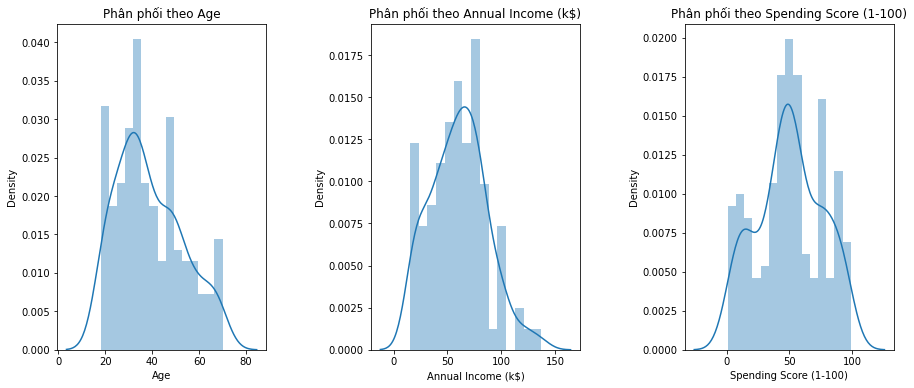

In [179]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(data[x] , bins = 15)
    plt.title('Phân phối theo {}'.format(x))
plt.show()

### Mối tương quan giữa các chiều dữ liệu 

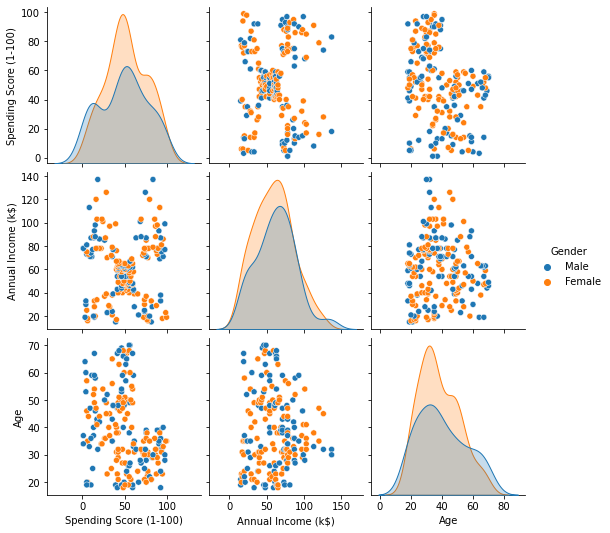

In [180]:
sns.pairplot(data, vars = ['Spending Score (1-100)', 'Annual Income (k$)', 'Age'], hue = "Gender")

##### Nhận xét : Dựa vào biểu đồ thấy:
- Không có sự chênh lệch giữa giới tính rõ ràng
- Có sự tương quan giữa mức thu nhập và số điểm chỉ tiêu của khách hàng rõ ràng
- Có mối tương quan giữa số điểm chỉ tiêu và độ tuổi của khách hàng

In [181]:
X = data.iloc[:, [3, 4]].values
Y = data.iloc[:,[2,4]].values
Z = data.iloc[:, [2, 3]].values

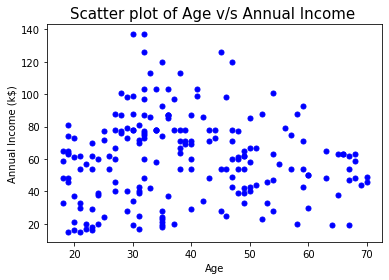

In [182]:
plt.title('Scatter plot of Age v/s Annual Income ', fontsize = 15)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.plot(Z[:, 0], Z[:, 1], 'bo', markersize=5)
plt.plot()
plt.show()

In [183]:
n_clusterZ = 3

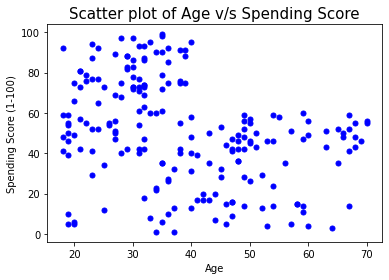

In [184]:
plt.title('Scatter plot of Age v/s Spending Score', fontsize = 15)
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.plot(Y[:, 0], Y[:, 1], 'bo', markersize=5)
plt.plot()
plt.show()

In [185]:
n_clusterY = 2

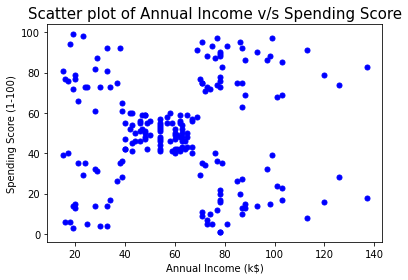

In [186]:
plt.title('Scatter plot of Annual Income v/s Spending Score', fontsize = 15)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
plt.plot()
plt.show()

In [187]:
n_clusterX = 5

### TỔNG QUÁT K-MEAN
- Cố định tâm- chọn bất kỳ k điểm làm k tâm
- Tìm dữ liệu thuộc cụm 
- Cố định dữ liệu => tìm tâm mới
- Lặp lại cho đến khi tâm không đổi

In [188]:
# Khơi tạo tâm cụm 
# khởi tạo n_cluster tâm cụm bằng cách lấy ngẫu nhiên n_cluster điểm dữ liệu của tập dữ liệu.
def kmeans_init_centers(X, n_cluster):
  # random k index beetween 0 and shape(X) without duplicate index.
  # Then return X[index] as cluster
    return X[np.random.choice(X.shape[0], n_cluster, replace=False)]

# Xác định các tâm cụm
def kmeans_predict_labels(X, centers):
      D = cdist(X, centers)
        # tính khoảng cách giữa điểm dữ liệu với tâm 
      # return index of the closest center
      return np.argmin(D, axis = 1) # trung bình cộng các điểm

# Cập nhật lại vị trí của các tâm cụm
def kmeans_update_centers(X, labels, n_cluster):
    centers = np.zeros((n_cluster, X.shape[1]))
    for k in range(n_cluster):
        # thu thập tất cả các điểm được chỉ định cho cụm thứ k
        Xk = X[labels == k, :]
        # lấy trung bình của các điểm 
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

# Kiểm tra tính hội tụ
def kmeans_has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [189]:
# Hàm vẽ 
def kmeans_visualize(X, centers, labels, n_cluster, title):
    plt.xlabel('x') # label trục x
    plt.ylabel('y') # label trục y
    plt.title(title) # title của đồ thị
    plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'tab:orange', 'tab:brown'] # danh sách các màu hỗ trợ
    
    for i in range(n_cluster):
        data = X[labels == i] # lấy dữ liệu của cụm i
        plt.plot(data[:, 0], data[:, 1], plt_colors[i] + '^', markersize = 5, label = 'cụm_' + str(i)) 
        # Vẽ cụm i lên đồ thị
        plt.plot(centers[i][0], centers[i][1],  'black',marker = 'o', markersize = 7, label = 'tâm_' + str(i)) 
        # Vẽ tâm cụm i lên đồ thị
    plt.legend() # Hiện bảng chú thích
    plt.show()
 

In [190]:
#Hàm Kmean
def kmeans(init_centes, init_labels, X, n_cluster):
    centers = init_centes
    labels = init_labels
    times = 0
    while True:
        # xác định tâm cụm
        labels = kmeans_predict_labels(X, centers)
        # vẽ dữ liệu
        kmeans_visualize(X, centers, labels, n_cluster, 'Assigned label for data at time = ' + str(times + 1))
        
        new_centers = kmeans_update_centers(X, labels, n_cluster)
        # nếu tâm cụm ko còn thay đổi
        if kmeans_has_converged(centers, new_centers):
            break
        centers = new_centers
        kmeans_visualize(X, centers, labels, n_cluster, 'Update center possition at time = ' + str(times + 1))
        times += 1
    return (centers, labels, times)

[[57 51]
 [48 42]]


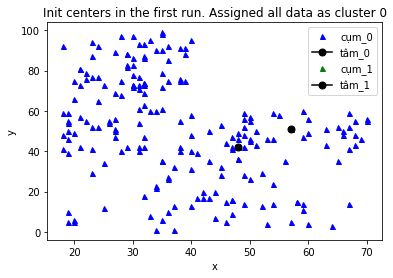

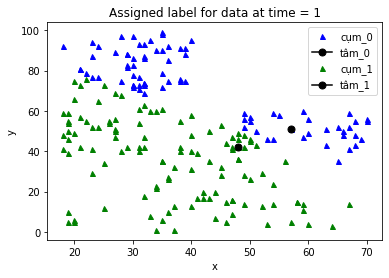

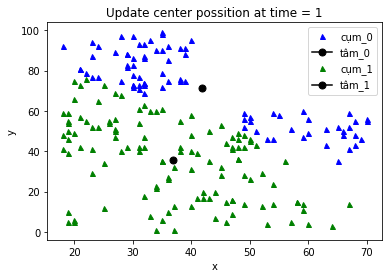

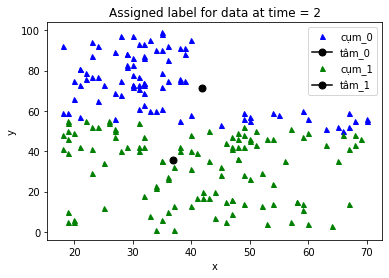

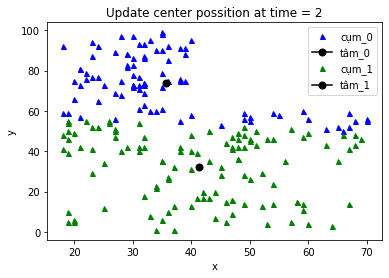

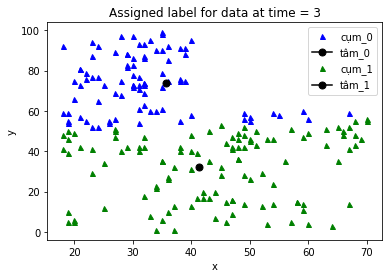

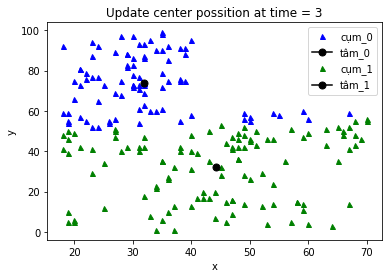

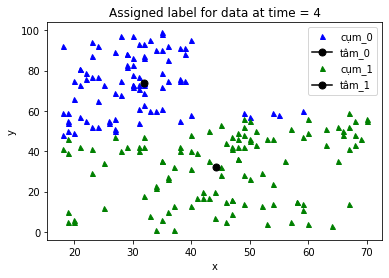

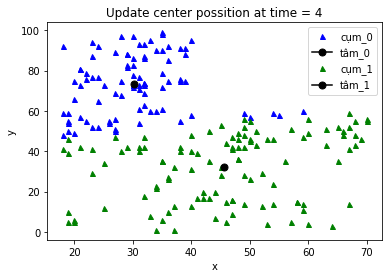

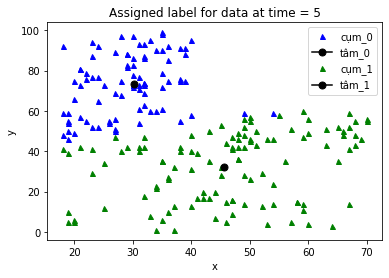

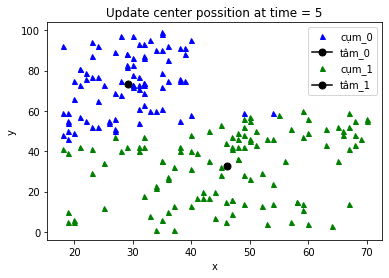

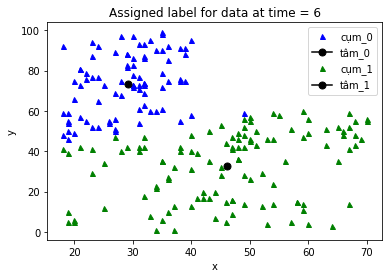

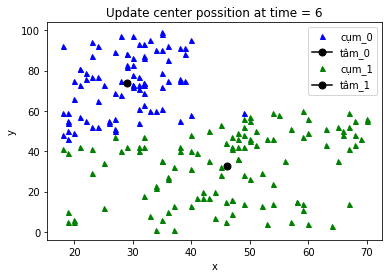

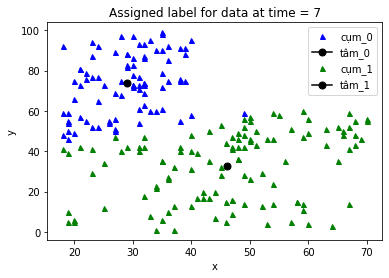

Done! Kmeans has converged after 6 times


In [192]:
plt.title('Phân cụm dựa trên Độ tuổi và Điểm chỉ tiêu')
init_centers = kmeans_init_centers(Y, n_clusterY)
print(init_centers) # In ra tọa độ khởi tạo ban đầu của các tâm cụm
init_labels = np.zeros(Y.shape[0])
kmeans_visualize(Y, init_centers, init_labels, n_clusterY, 'Init centers in the first run. Assigned all data as cluster 0')
centers, labels, times = kmeans(init_centers, init_labels, Y, n_clusterY)
 
print('Done! Kmeans has converged after', times, 'times')

##### Nhận xét:
- Khách hàng trẻ thì đa phần có điểm chi tiêu cao hơn so với khác hàng lớn tuổi

[[43 41]
 [54 48]
 [57 58]
 [60 42]
 [65 59]]


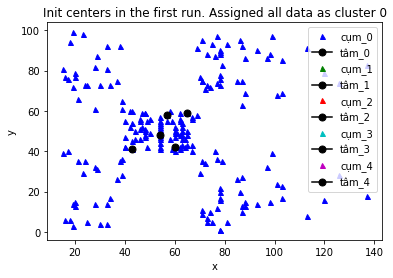

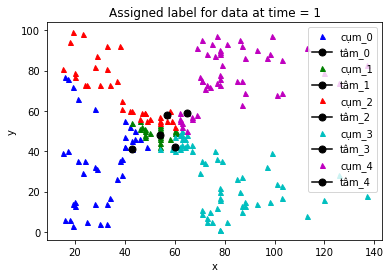

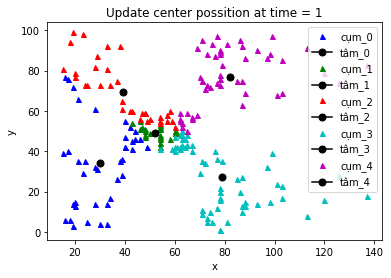

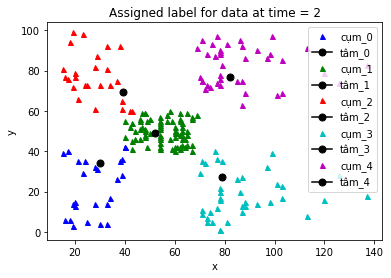

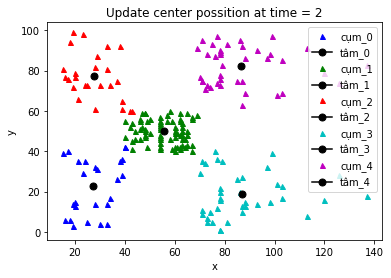

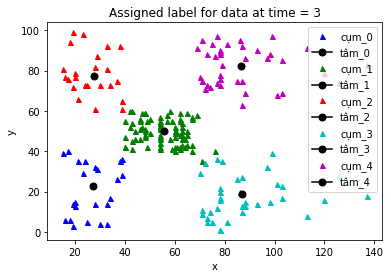

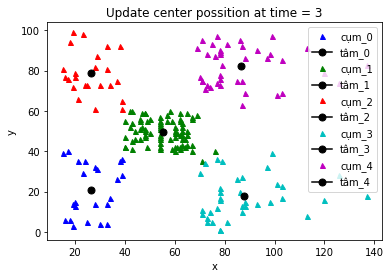

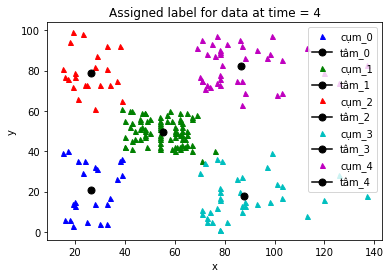

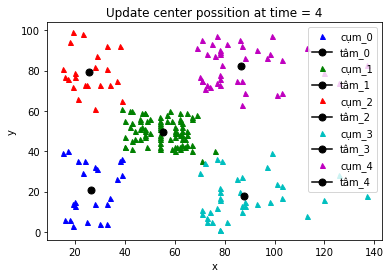

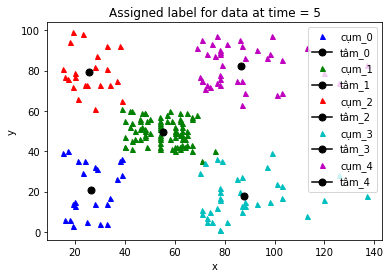

Done! Kmeans has converged after 4 times


In [193]:
plt.title('Phân cụm dựa trên Mức thu nhập và Điểm chi tiêu')
init_centers = kmeans_init_centers(X, n_clusterX)
print(init_centers) # In ra tọa độ khởi tạo ban đầu của các tâm cụm
init_labels = np.zeros(X.shape[0])
kmeans_visualize(X, init_centers, init_labels, n_clusterX, 'Init centers in the first run. Assigned all data as cluster 0')
centers, labels, times = kmeans(init_centers, init_labels, X, n_clusterX)
 
print('Done! Kmeans has converged after', times, 'times')

###### Nhận xét:
- Người có thu nhập hằng năm khoảng từ trên 40 - dưới 70 thì điểm chi tiêu ổn định trung bình từ 40-60
- Khoảng 50% Người có mức thu nhập hằng năm trên 70k có điểm chi tiêu cao nhiều và cũng có điểm chi tiêu thấp nhiều nhất 
- khoảng 50% Người có mức thu nhập hằng năm dưới 40k có điểm chi tiêu cao và 50% có điểm chi tiêu thấp 